In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Twitter16-RNR"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Twitter16-RNR_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
first = vectors[0]
vectors.shape

(818, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter16_dataset_with_tvt.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt,cv_fold,tt,tvt2,tvt2_1,tvt2_2,tvt2_3
0,656955120626880512,correct predictions in back to the future ii U...,false,training,1,training,validation,training,training,validation
1,615689290706595840,.@whitehouse in rainbow colors for #scotusmarr...,true,training,3,training,training,validation,training,training
2,613404935003217920,cops bought the alleged church shooter burger ...,false,training,2,test,training,training,training,training
3,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,training,3,test,training,training,training,training
4,714598641827246081,an open letter to trump voters from his top st...,unverified,training,1,test,training,validation,training,training


In [4]:
labels_str = ['rumour', 'non-rumour']
labels_str

['rumour', 'non-rumour']

In [5]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] in ['true', 'false', 'unverified']:
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(545, 768)
(192, 768)
(81, 768)
(545,)
(192,)
(81,)


In [8]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(737, 768)


In [9]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(737,)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes):
        super(BasicBlock, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.bn2(self.lin2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(Bottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, n_input=768, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 512

        self.lin1 = nn.Linear(n_input, self.in_planes)
        self.bn1 = nn.BatchNorm1d(self.in_planes)
        self.layer1 = self._make_layer(block, 512, num_blocks[0])
        self.layer2 = self._make_layer(block, 256, num_blocks[1])
        self.layer3 = self._make_layer(block, 128, num_blocks[2])
        self.layer4 = self._make_layer(block, 64, num_blocks[3])
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks):
        strides = [1] * num_blocks
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet10(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [1, 1, 1, 1], n_input, n_output)

    
def ResNet18(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [2, 2, 2, 2], n_input, n_output)


def ResNet34(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [3, 4, 6, 3], n_input, n_output)


def ResNet50(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 4, 6, 3], n_input, n_output)


def ResNet101(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 4, 23, 3], n_input, n_output)


def ResNet152(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 8, 36, 3], n_input, n_output)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(CNNBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(CNNBottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNNResNet, self).__init__()
        self.in_planes = 24

        self.conv1 = nn.Conv2d(1, 24, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.layer1 = self._make_layer(block, 24, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.linear = nn.Linear(64 * 24 * 32, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def CNNResNet10(n_output: int):
    return CNNResNet(CNNBasicBlock, [1, 1, 1, 1], n_output)

    
def CNNResNet18(n_output: int):
    return CNNResNet(CNNBasicBlock, [2, 2, 2, 2], n_output)


def CNNResNet34(n_output: int):
    return CNNResNet(CNNBasicBlock, [3, 4, 6, 3], n_output)


def CNNResNet50(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 4, 6, 3], n_output)


def CNNResNet101(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 4, 23, 3], n_output)


def CNNResNet152(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 8, 36, 3], n_output)

In [12]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class ResNetClassifier(nn.Module):
    def __init__(self,
        model,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        n_features: int = 4,
        lr: float = 0.0002,
        beta1: float = 0.5,
        device: str = None,
        model_type: str = "mlp"
    ):
        super(ResNetClassifier, self).__init__()
        self.model = model
        self.model_type = model_type
        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

    def forward(self, input):
        x = self.model(input)
        return x
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                if self.model_type == "cnn":
                    outputs = self.model(inputs.unsqueeze(1))
                elif self.model_type == "mlp":
                    outputs = self.model(inputs)

                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()


            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    
                    if self.model_type == 'mlp':
                        outputs = self.model(inputs)
                    else:
    #                     outputs = self.model(inputs.reshape(inputs.shape[0], 1, 24, 32))
                        outputs = self.model(inputs.unsqueeze(1))

                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()

                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                    # if self.model_type == 'mlp':
                    #     preds = self.predict(test_x)
                    # else:
                    #     preds = self.predict(test_x.reshape(test_x.shape[0], 1, 24, 32))
                    # conf_mat = ConfusionMatrix(
                    #     labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y]),
                    #     predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()]),
                    #     binary=False
                    # )
                    # conf_mat.evaluate(logs=False)
                    # test_acc = conf_mat.accuracy
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break

         # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_ResNet10_CNN_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_ResNet10_CNN_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [13]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

--- FOLD 1 ----
Multiclass Classification Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold1
Using cuda
Saving after new best accuracy : 75.0
Saving after new best accuracy : 93.91891891891892
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 99.830220713073, Validation Accuracy : 100.0, Train Loss : 0.012575644999742508, Validation Loss : 0.006453333422541618
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0033973093377426267, Validation Loss : 0.0038950257003307343
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0016193598858080804, Validation Loss : 0.003172151045873761
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0009587926906533539, Validation Loss : 0.0028373650275170803
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0006378145917551592, Validation Loss : 0.0026446206029504538
-- Epoch 300, Train_Accuracy : 100.0, Validatio

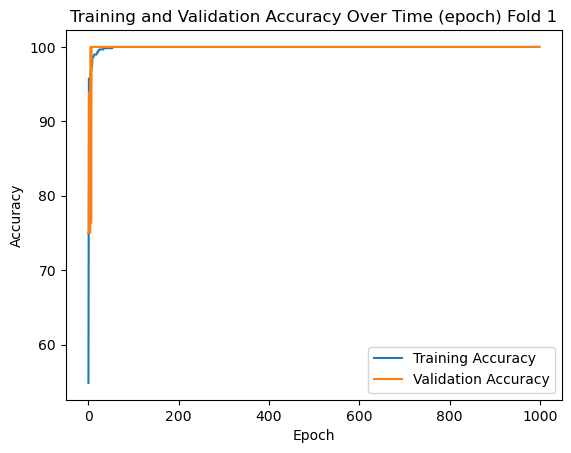

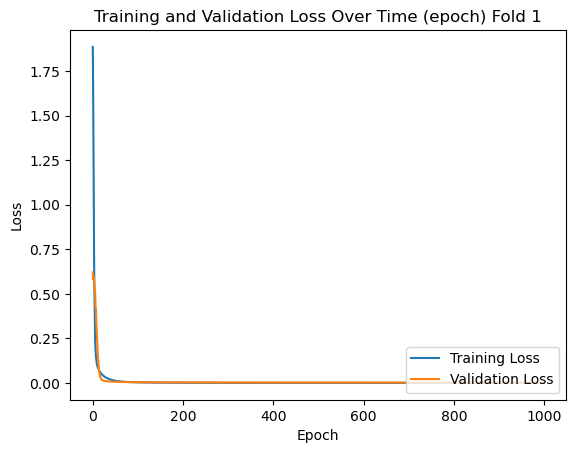

Exec Time : 130.15 seconds

---- Train Set ----
Predictions : torch.Size([589])
Binary Class Evaluation

True Positive : 128
False Positive : 8
False Negative : 20
True Negative : 433

Class non-rumour Evaluation
- Precision : 94.118 %
- Recall : 86.486 %
- F1 : 0.90141

Class rumour Evaluation
- Precision : 95.585 %
- Recall : 98.186 %
- F1 : 0.96868

Combined Evaluation
- Accuracy : 95.246 %
- Precision : 94.851 %
- Recall : 92.336 %
- F1 : 0.93577
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Train, 95.246, 94.851, 92.336, 0.93577, 94.118, 86.486, 0.90141, 95.585, 98.186, 0.96868, 
Confusion Matrix Scikit-learn: 
[[433   8]
 [ 20 128]]


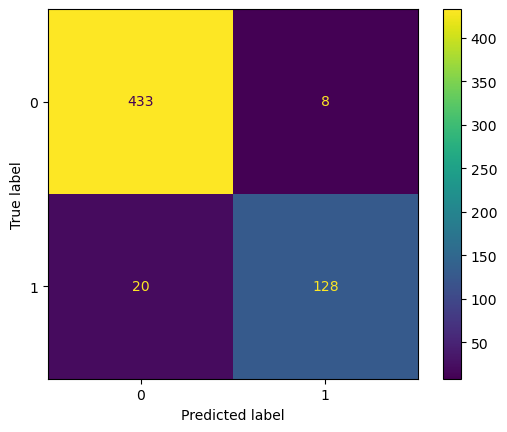


---- Validation Set ----
Predictions : torch.Size([148])
Binary Class Evaluation

True Positive : 37
False Positive : 0
False Negative : 0
True Negative : 111

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[111   0]
 [  0  37]]


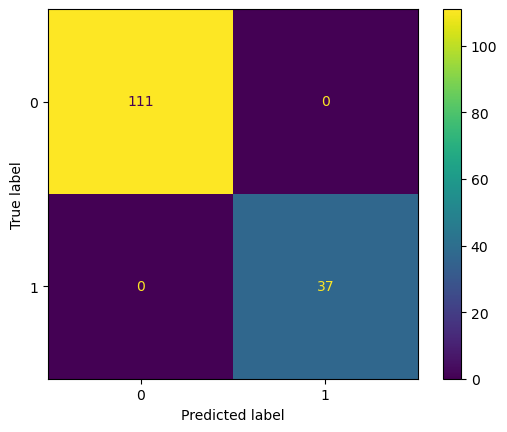


---- Test Set ----
Predictions : torch.Size([81])
Binary Class Evaluation

True Positive : 11
False Positive : 0
False Negative : 9
True Negative : 61

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 55.0 %
- F1 : 0.70968

Class rumour Evaluation
- Precision : 87.143 %
- Recall : 100.0 %
- F1 : 0.9313

Combined Evaluation
- Accuracy : 88.889 %
- Precision : 93.571 %
- Recall : 77.5 %
- F1 : 0.84781
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Test, 88.889, 93.571, 77.5, 0.84781, 100.0, 55.0, 0.70968, 87.143, 100.0, 0.9313, 
81
81
Confusion Matrix Scikit-learn: 
[[61  0]
 [ 9 11]]


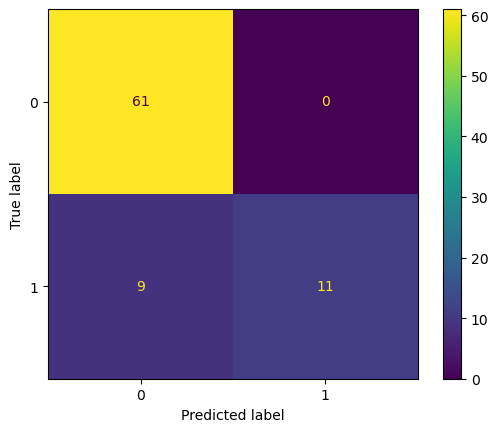

--- FOLD 2 ----
Multiclass Classification Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold2
Using cuda
Saving after new best accuracy : 75.0
Saving after new best accuracy : 99.32432432432432
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 99.830220713073, Validation Accuracy : 100.0, Train Loss : 0.012107312679290771, Validation Loss : 0.0053376504220068455
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.003254236769862473, Validation Loss : 0.002236194908618927
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.001544795697554946, Validation Loss : 0.001399555942043662
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0009129407117143273, Validation Loss : 0.0010181124089285731
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0006068107322789729, Validation Loss : 0.0008001048699952662
-- Epoch 300, Train_Accuracy : 100.0, Validation 

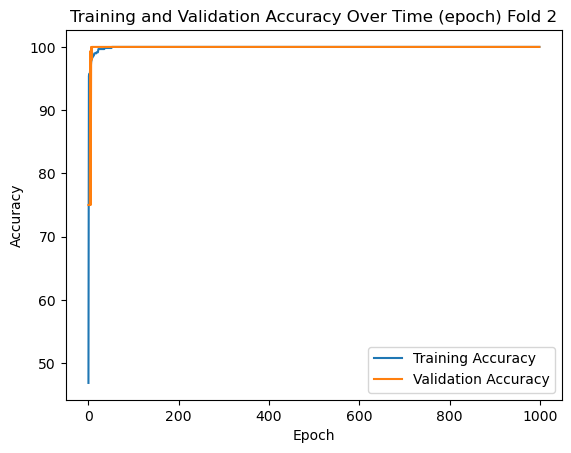

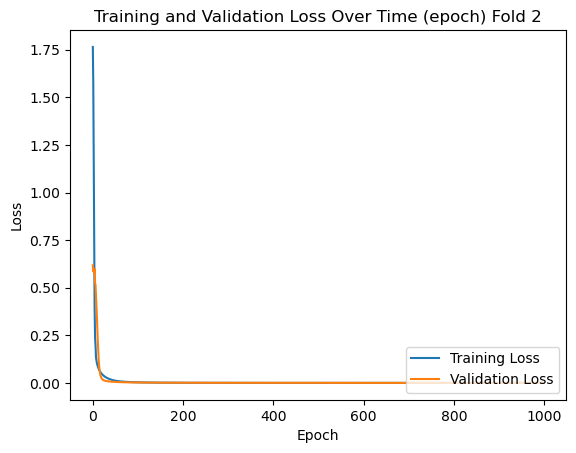

Exec Time : 126.36 seconds

---- Train Set ----
Predictions : torch.Size([589])
Binary Class Evaluation

True Positive : 130
False Positive : 6
False Negative : 18
True Negative : 435

Class non-rumour Evaluation
- Precision : 95.588 %
- Recall : 87.838 %
- F1 : 0.91549

Class rumour Evaluation
- Precision : 96.026 %
- Recall : 98.639 %
- F1 : 0.97315

Combined Evaluation
- Accuracy : 95.925 %
- Precision : 95.807 %
- Recall : 93.239 %
- F1 : 0.94506
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Train, 95.925, 95.807, 93.239, 0.94506, 95.588, 87.838, 0.91549, 96.026, 98.639, 0.97315, 
Confusion Matrix Scikit-learn: 
[[435   6]
 [ 18 130]]


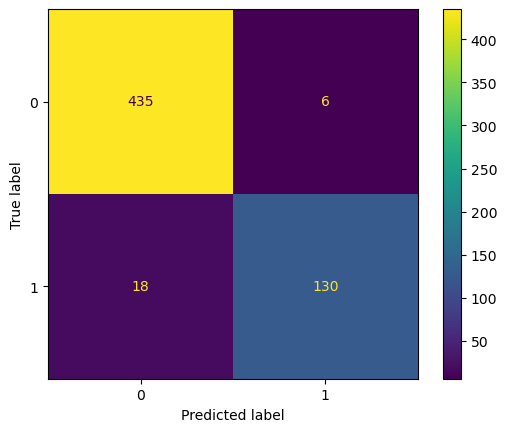


---- Validation Set ----
Predictions : torch.Size([148])
Binary Class Evaluation

True Positive : 37
False Positive : 0
False Negative : 0
True Negative : 111

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[111   0]
 [  0  37]]


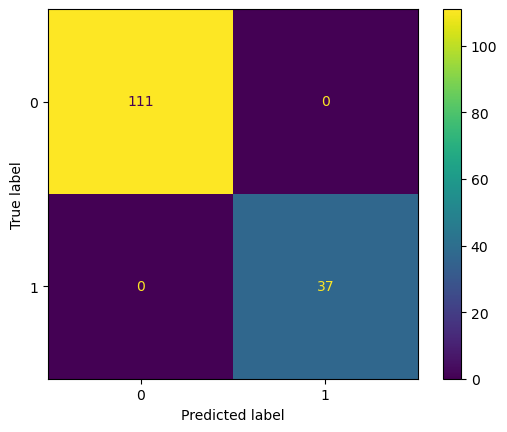


---- Test Set ----
Predictions : torch.Size([81])
Binary Class Evaluation

True Positive : 11
False Positive : 0
False Negative : 9
True Negative : 61

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 55.0 %
- F1 : 0.70968

Class rumour Evaluation
- Precision : 87.143 %
- Recall : 100.0 %
- F1 : 0.9313

Combined Evaluation
- Accuracy : 88.889 %
- Precision : 93.571 %
- Recall : 77.5 %
- F1 : 0.84781
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Test, 88.889, 93.571, 77.5, 0.84781, 100.0, 55.0, 0.70968, 87.143, 100.0, 0.9313, 
81
81
Confusion Matrix Scikit-learn: 
[[61  0]
 [ 9 11]]


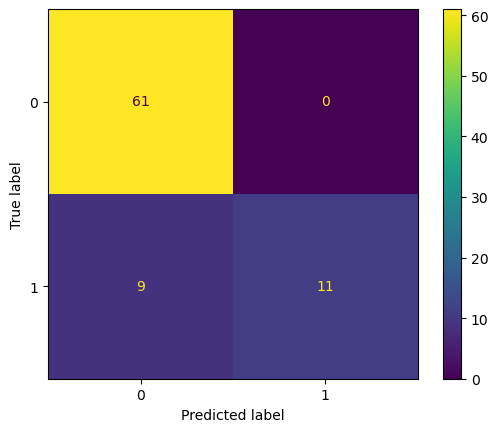

--- FOLD 3 ----
Multiclass Classification Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold3
Using cuda
Saving after new best accuracy : 95.91836734693878
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 99.83050847457628, Validation Accuracy : 100.0, Train Loss : 0.013116053305566311, Validation Loss : 0.005778100341558456
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0037176284240558743, Validation Loss : 0.0023997188545763493
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0017894155462272465, Validation Loss : 0.0014513627393171191
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0010630777978803962, Validation Loss : 0.0010253866203129292
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0007087117701303214, Validation Loss : 0.0007875759620219469
-- Epoch 300, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.

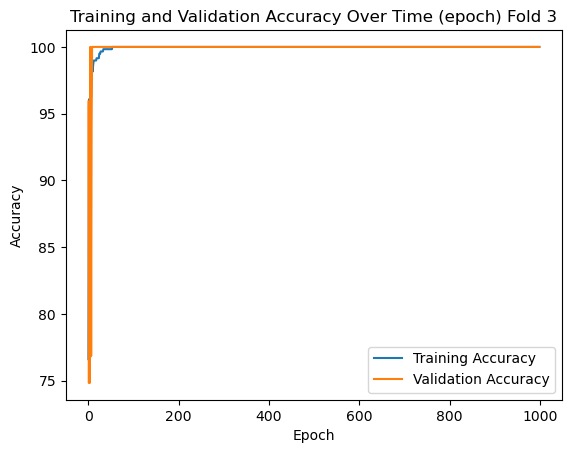

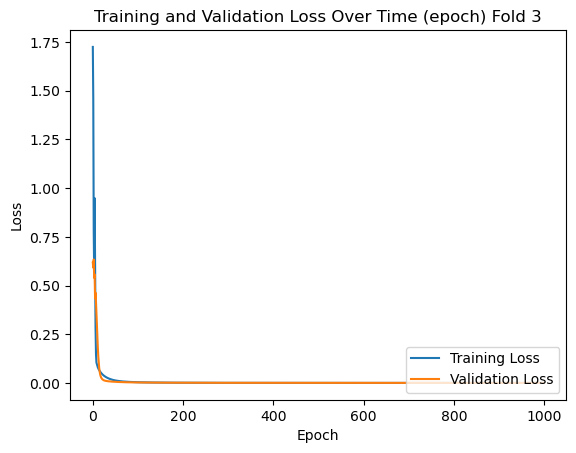

Exec Time : 126.37 seconds

---- Train Set ----
Predictions : torch.Size([590])
Binary Class Evaluation

True Positive : 134
False Positive : 11
False Negative : 14
True Negative : 431

Class non-rumour Evaluation
- Precision : 92.414 %
- Recall : 90.541 %
- F1 : 0.91468

Class rumour Evaluation
- Precision : 96.854 %
- Recall : 97.511 %
- F1 : 0.97182

Combined Evaluation
- Accuracy : 95.763 %
- Precision : 94.634 %
- Recall : 94.026 %
- F1 : 0.94329
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Train, 95.763, 94.634, 94.026, 0.94329, 92.414, 90.541, 0.91468, 96.854, 97.511, 0.97182, 
Confusion Matrix Scikit-learn: 
[[431  11]
 [ 14 134]]


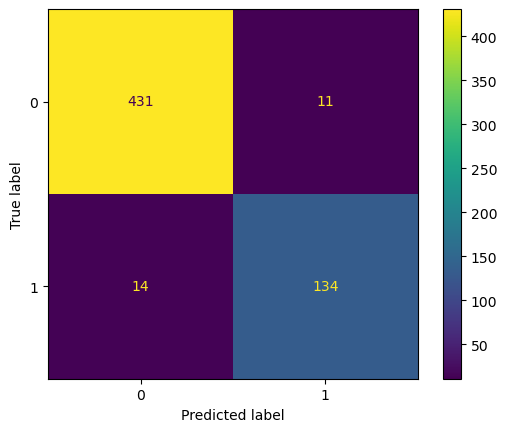


---- Validation Set ----
Predictions : torch.Size([147])
Binary Class Evaluation

True Positive : 37
False Positive : 0
False Negative : 0
True Negative : 110

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[110   0]
 [  0  37]]


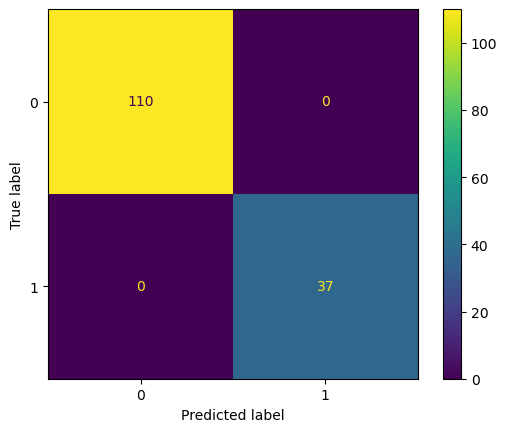


---- Test Set ----
Predictions : torch.Size([81])
Binary Class Evaluation

True Positive : 14
False Positive : 0
False Negative : 6
True Negative : 61

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 70.0 %
- F1 : 0.82353

Class rumour Evaluation
- Precision : 91.045 %
- Recall : 100.0 %
- F1 : 0.95312

Combined Evaluation
- Accuracy : 92.593 %
- Precision : 95.522 %
- Recall : 85.0 %
- F1 : 0.89954
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Test, 92.593, 95.522, 85.0, 0.89954, 100.0, 70.0, 0.82353, 91.045, 100.0, 0.95312, 
81
81
Confusion Matrix Scikit-learn: 
[[61  0]
 [ 6 14]]


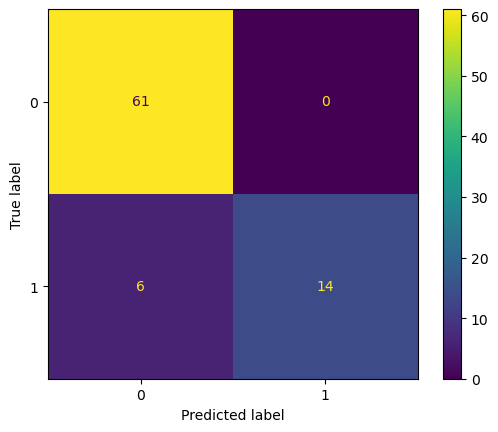

--- FOLD 4 ----
Multiclass Classification Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold4
Using cuda
Saving after new best accuracy : 83.6734693877551
Saving after new best accuracy : 97.95918367346938
Saving after new best accuracy : 98.63945578231292
-- Epoch 50, Train_Accuracy : 99.83050847457628, Validation Accuracy : 98.63945578231292, Train Loss : 0.012722776737064123, Validation Loss : 0.03813781589269638
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 98.63945578231292, Train Loss : 0.003503951709717512, Validation Loss : 0.03492745757102966
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 98.63945578231292, Train Loss : 0.00167269998928532, Validation Loss : 0.03455023095011711
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 98.63945578231292, Train Loss : 0.0009915655828081071, Validation Loss : 0.034611597657203674
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 98.63945578231292, Train Loss : 0.0006597304018214345, Validatio

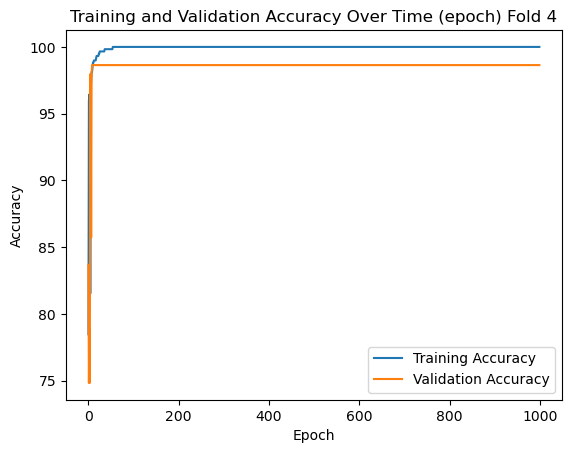

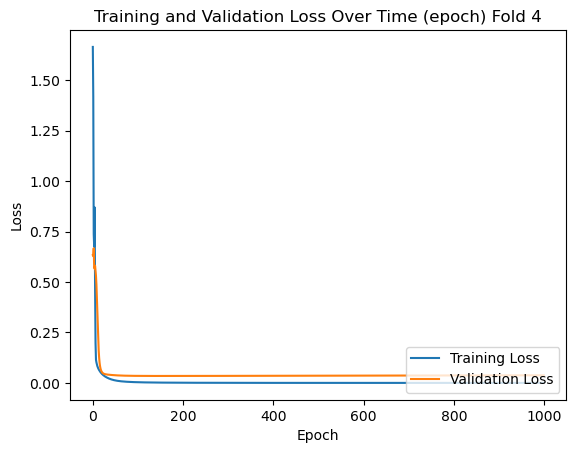

Exec Time : 125.88 seconds

---- Train Set ----
Predictions : torch.Size([590])
Binary Class Evaluation

True Positive : 137
False Positive : 9
False Negative : 11
True Negative : 433

Class non-rumour Evaluation
- Precision : 93.836 %
- Recall : 92.568 %
- F1 : 0.93197

Class rumour Evaluation
- Precision : 97.523 %
- Recall : 97.964 %
- F1 : 0.97743

Combined Evaluation
- Accuracy : 96.61 %
- Precision : 95.679 %
- Recall : 95.266 %
- F1 : 0.95472
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Train, 96.61, 95.679, 95.266, 0.95472, 93.836, 92.568, 0.93197, 97.523, 97.964, 0.97743, 
Confusion Matrix Scikit-learn: 
[[433   9]
 [ 11 137]]


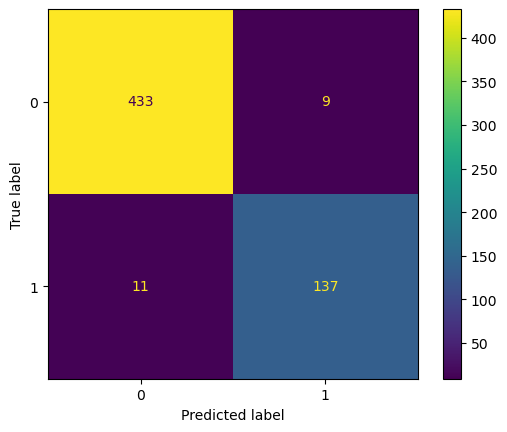


---- Validation Set ----
Predictions : torch.Size([147])
Binary Class Evaluation

True Positive : 36
False Positive : 1
False Negative : 1
True Negative : 109

Class non-rumour Evaluation
- Precision : 97.297 %
- Recall : 97.297 %
- F1 : 0.97297

Class rumour Evaluation
- Precision : 99.091 %
- Recall : 99.091 %
- F1 : 0.99091

Combined Evaluation
- Accuracy : 98.639 %
- Precision : 98.194 %
- Recall : 98.194 %
- F1 : 0.98194
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Validation, 98.639, 98.194, 98.194, 0.98194, 97.297, 97.297, 0.97297, 99.091, 99.091, 0.99091, 
Confusion Matrix Scikit-learn: 
[[109   1]
 [  1  36]]


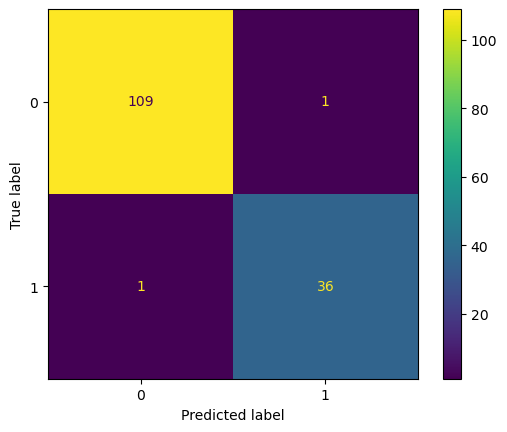


---- Test Set ----
Predictions : torch.Size([81])
Binary Class Evaluation

True Positive : 14
False Positive : 1
False Negative : 6
True Negative : 60

Class non-rumour Evaluation
- Precision : 93.333 %
- Recall : 70.0 %
- F1 : 0.8

Class rumour Evaluation
- Precision : 90.909 %
- Recall : 98.361 %
- F1 : 0.94488

Combined Evaluation
- Accuracy : 91.358 %
- Precision : 92.121 %
- Recall : 84.18 %
- F1 : 0.87972
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Test, 91.358, 92.121, 84.18, 0.87972, 93.333, 70.0, 0.8, 90.909, 98.361, 0.94488, 
81
81
Confusion Matrix Scikit-learn: 
[[60  1]
 [ 6 14]]


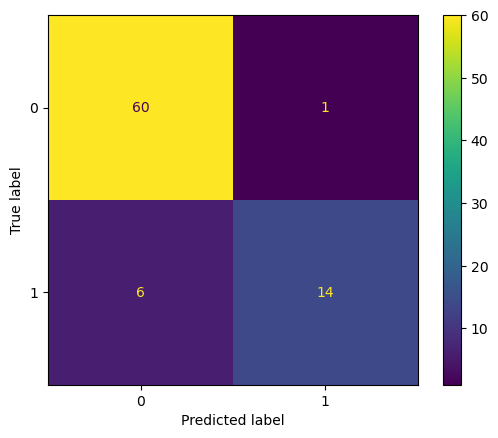

--- FOLD 5 ----
Multiclass Classification Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold5
Using cuda
Saving after new best accuracy : 74.14965986394557
Saving after new best accuracy : 74.82993197278911
Saving after new best accuracy : 83.6734693877551
Saving after new best accuracy : 84.35374149659864
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 78.91156462585035, Train Loss : 0.0002353490999666974, Validation Loss : 2.0800881385803223
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 78.91156462585035, Train Loss : 9.43000050028786e-05, Validation Loss : 2.124927282333374
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 78.91156462585035, Train Loss : 5.49682790733641e-05, Validation Loss : 2.1552329063415527
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 78.91156462585035, Train Loss : 3.704475193444523e-05, Validation Loss : 2.178950309753418
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 78.91156462585035, Train Loss 

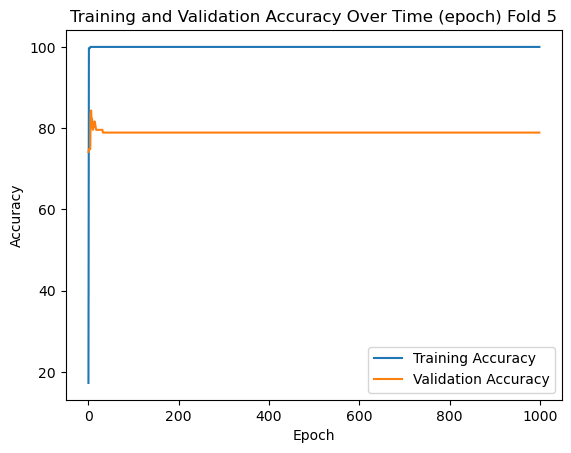

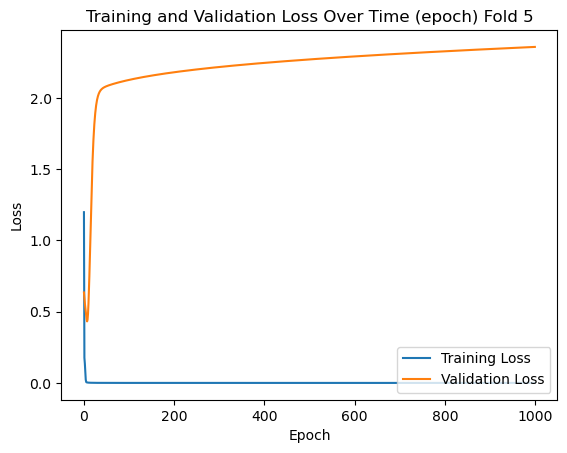

Exec Time : 125.99 seconds

---- Train Set ----
Predictions : torch.Size([590])
Binary Class Evaluation

True Positive : 143
False Positive : 0
False Negative : 5
True Negative : 442

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 96.622 %
- F1 : 0.98282

Class rumour Evaluation
- Precision : 98.881 %
- Recall : 100.0 %
- F1 : 0.99438

Combined Evaluation
- Accuracy : 99.153 %
- Precision : 99.441 %
- Recall : 98.311 %
- F1 : 0.98873
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Train, 99.153, 99.441, 98.311, 0.98873, 100.0, 96.622, 0.98282, 98.881, 100.0, 0.99438, 
Confusion Matrix Scikit-learn: 
[[442   0]
 [  5 143]]


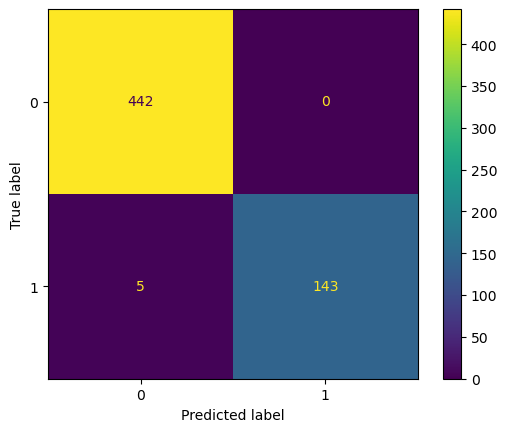


---- Validation Set ----
Predictions : torch.Size([147])
Binary Class Evaluation

True Positive : 19
False Positive : 5
False Negative : 18
True Negative : 105

Class non-rumour Evaluation
- Precision : 79.167 %
- Recall : 51.351 %
- F1 : 0.62295

Class rumour Evaluation
- Precision : 85.366 %
- Recall : 95.455 %
- F1 : 0.90129

Combined Evaluation
- Accuracy : 84.354 %
- Precision : 82.266 %
- Recall : 73.403 %
- F1 : 0.77582
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Validation, 84.354, 82.266, 73.403, 0.77582, 79.167, 51.351, 0.62295, 85.366, 95.455, 0.90129, 
Confusion Matrix Scikit-learn: 
[[105   5]
 [ 18  19]]


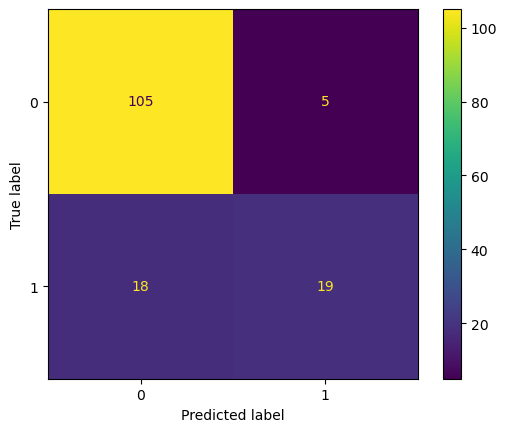


---- Test Set ----
Predictions : torch.Size([81])
Binary Class Evaluation

True Positive : 10
False Positive : 0
False Negative : 10
True Negative : 61

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 50.0 %
- F1 : 0.66667

Class rumour Evaluation
- Precision : 85.915 %
- Recall : 100.0 %
- F1 : 0.92424

Combined Evaluation
- Accuracy : 87.654 %
- Precision : 92.958 %
- Recall : 75.0 %
- F1 : 0.83019
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Test, 87.654, 92.958, 75.0, 0.83019, 100.0, 50.0, 0.66667, 85.915, 100.0, 0.92424, 
81
81
Confusion Matrix Scikit-learn: 
[[61  0]
 [10 10]]


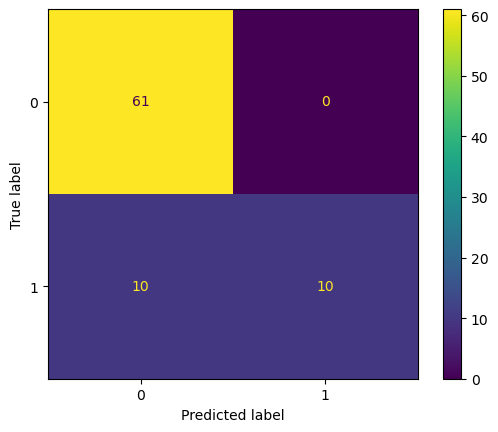

In [14]:
for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
    
    model_name = f"{dataset_name}_ResNet10_CNN_{unique_name}_Fold{i+1}"
    start = time.time()
    print(f"Multiclass Classification {model_name}")
    model = ResNetClassifier(CNNResNet10(n_output=2), train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss, n_features=16, model_type="cnn") #, device="cpu")
    model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\n---- Train Set ----")
    preds = model.predict(train_vectors.reshape(train_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\n---- Validation Set ----")
    preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\n---- Test Set ----")
    preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

In [15]:
# model_name = f"{dataset_name}_ResNet18_CNN_{unique_name}"
# start = time.time()
# print(f"Multiclass Classification {model_name}")
# model = ResNetClassifier(CNNResNet18(n_output=4), train_vectors.shape[1], n_output=4, criterion=nn.CrossEntropyLoss, n_features=16, model_type="cnn") #, device="cpu")
# model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
#                 torch.Tensor(train_labels),
#                 torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
#                 torch.Tensor(val_labels),
#                 saves=model_name,
#                 n_iter=1000,
#                 batch_size=1024)
# print(f"Exec Time : {round(time.time() - start, 2)} seconds")

# model.load_pretrained(f"../../data/models/{model_name}.pth")

# print("\n---- Train Set ----")
# preds = model.predict(train_vectors.reshape(train_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(train_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Train"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(train_labels)
# predictions=np.array(preds)
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()

# print("\n---- Validation Set ----")
# preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(val_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Validation"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(val_labels)
# predictions=np.array(preds)
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()

# print("\n---- Test Set ----")
# preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(test_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Test"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(test_labels)
# predictions=np.array(preds)
# print(len(labels))
# print(len(predictions))
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()